# Bank Account Fraud Detection

## Luke DiPerna

### January 2023


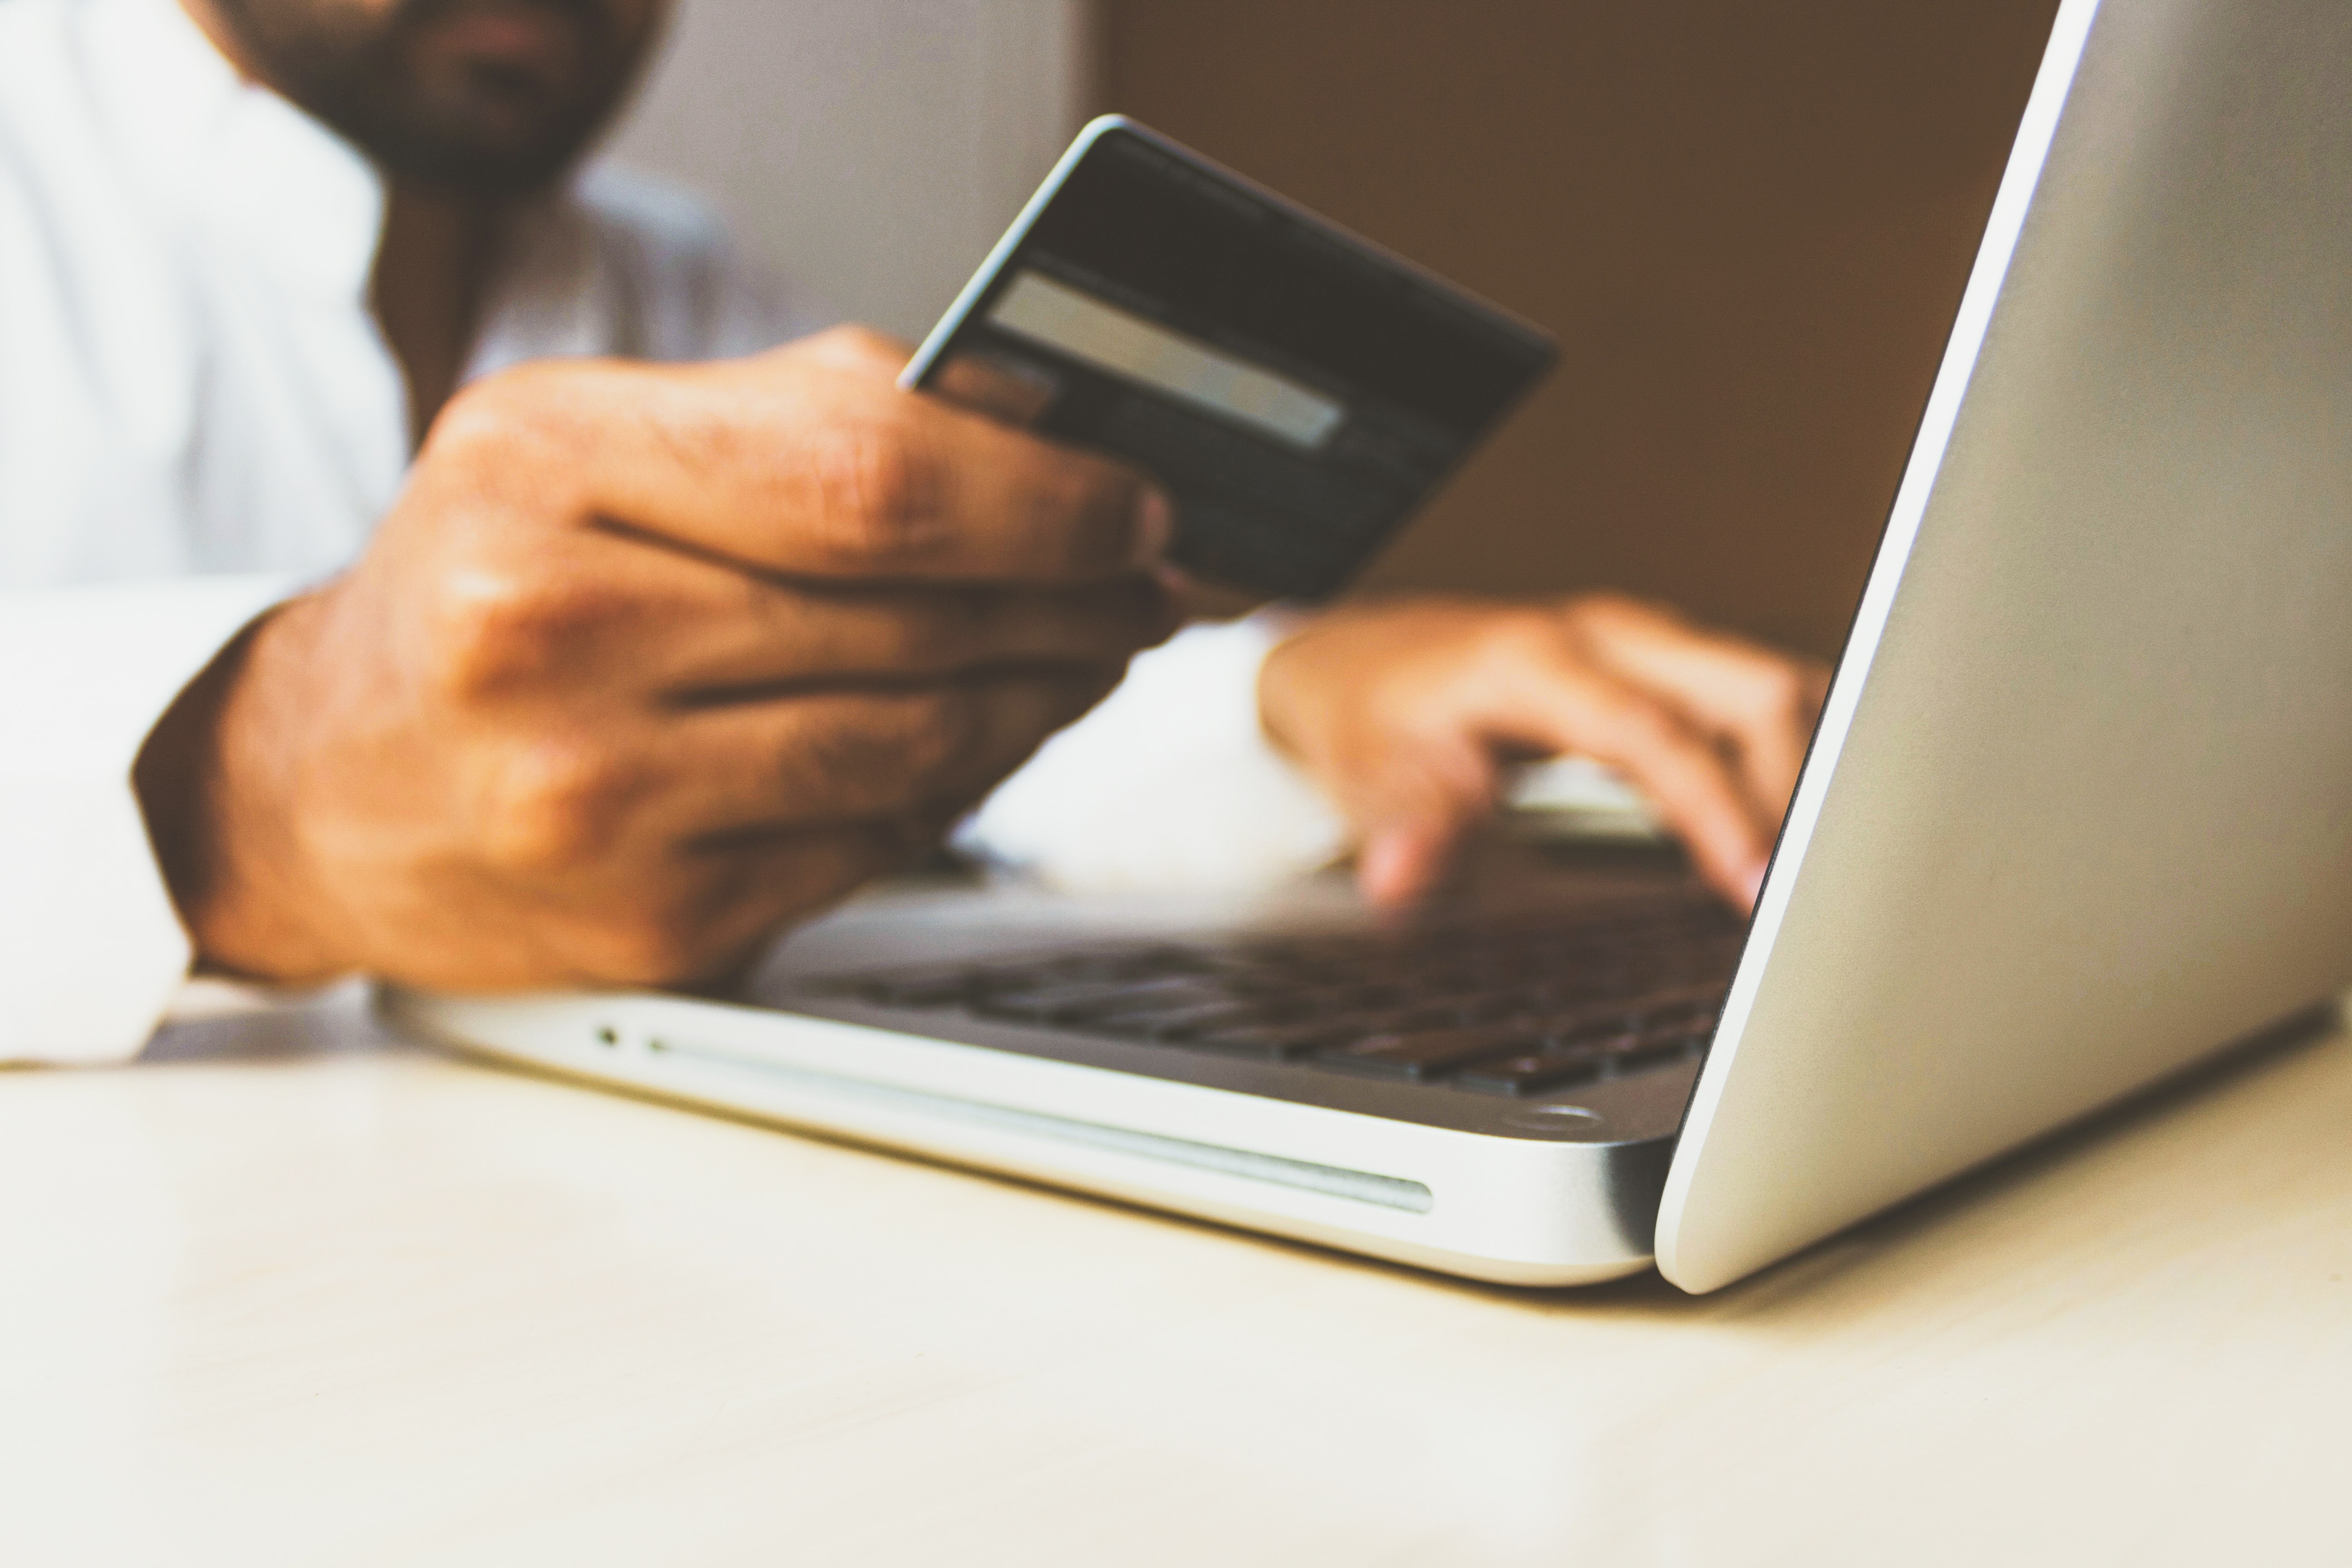

Photo by <a href="https://unsplash.com/@rupixen?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">rupixen.com</a> on <a href="https://unsplash.com/s/photos/credit-card?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

## Project Goal
***
The goal of this project is to accurately and responsibly predict fraudulent bank account applications. The stakeholder is the Office of the Comptroller of the Currency (OCC), an independent bureau of the US Department of the Treasury. The OCC is responsible for regulating and supervising all national banks.

With the rise in reliance on machine learning models to detect things like fraudulent bank account applications, there is growing concern about the bias that is often "built-in" to these models. There is more research than I can mention, but for a few brief examples, see:

- a [ProPublica study](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) on discrimination and recidivism (2016)
- a [White House report](https://obamawhitehouse.archives.gov/sites/default/files/microsites/ostp/2016_0504_data_discrimination.pdf) on algorithmic systems and civil rights (2016)
- a [research paper](https://arxiv.org/pdf/1908.09635.pdf) on bias and fairness in machine learning (2019)
    
The OCC, whose mission is in part to be a supervisor who "promotes a vibrant and diverse banking system that benefits consumers, communities, businesses, and the U.S. economy" ([link](https://www.occ.gov/about/index-about.html)), wishes to examine machine learning models and practices that will balance the needs of the banks while ensuring that consumers are not subject to discrimination and unfair treatment. In doing so, they can begin to establish industry standards to ensure that banks implement non-discriminatory practices.

As part of this, certain protected classes/information will be be anonymized. Additionally, since the dataset is heavily imbalanced, accuracy is not a suitable metric. Instead, models will be judged by their precision (true positive rate) at a set false positive rate. The results will also be analyzed to determine whether or not the models show bias toward any particular groups among the protected classes.

## Table of Contents
- [Data](#Data)
- [Methods and Metrics](#Methods-and-Metrics)
    - [Fairness and Bias Metrics](#Fairness-and-Bias-Metrics)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis(EDA))
- [Modeling](#Modeling)
    - [Custom Functions](#Custom-Functions)
    - [Baseline Model: Logistic Regression](#Baseline-Model:-Logistic-Regression)
    - [K-Nearest Neighbors(KNN)](#K-Nearest-Neighbors(KNN))
    - [Random Forests (RF)](#Random-Forests-(RF))
- [Model Evaluation](#Model-Evaluation)
- [Bias and Fairness Metrics](#Bias-and-Fairness-Metrics)

## Data
***
The dataset comes from a research study about the creation and use of tabular datasets for machine learning evaluation. The dataset, study, and explanatory information can be found at the following locations:

- [kaggle dataset](https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022)
- [github repository](https://github.com/feedzai/bank-account-fraud)
- [informational datasheet](https://github.com/feedzai/bank-account-fraud/blob/main/documents/datasheet.pdf)
- [research paper](https://arxiv.org/pdf/2211.13358.pdf)

These resources go into great detail about the dataset and the research behind it. In short, the dataset is a realistic dataset generated from actual bank account applications collected over a span of 8 months. There are no missing values, and certain identifying and protected information has been anonymized. The dataset also has 6 "variants," each with a few unique traits. However, I am only using the "Base" variant for this analysis.

"Base" dataset attributes:

- 1 million observations
- 30 features
- anonymized protected features

## Methods and Metrics
***
Because the dataset is extremely imbalanced, accuracy is not a suitable metric. A model that always predicts 'not fraudulent' would have an accuracy score of around 98.9% despite not identifying a single instance of fraud. Therefore, I will be using alternate metrics to evaluate the models. I will use the ROC (Receiver Operating Characteristic) curve to judge the models. With the ROC curve, I will calculate the AUC (area-under-curve), along with the TPR (true positive rate) of the model at a set FPR (false positive rate) threshold.

- **AUC**: gives an overall score of how well the model performs at each threshold. Scores range from 0-1 with 1 being a perfect model.
- **TPR at a set FPR**: this will give the TPR, also known as Recall, at a set level of FPR. For the purposes of this analysis, I will use a set FPR of 0.05 (5%). This means that the models will be judged on how well they can identify the true positive instances of fraud while allowing that the model will predict false positives 5% of the time.

The models will be trained on a training set using cross validation. From there, the models will be tuned until a "best" model is found. The best models will then be evaluated on the test set. Finally, a fairness and bias analysis will be performed on each model.

### Fairness and Bias Metrics

In order to evaluate fairness and bias, I will be using the [Aequitas Bias and Fairness Audit](https://dssg.github.io/aequitas/index.html) toolkit to determine if the models are biased against certain groups within the protected classes. Primarily, I will be looking at the FPR of each sub-group to determine if the applications of certain subgroups are being falsely identified as fraudulent at a disproportionate rate.

## Exploratory Data Analysis (EDA)
***
Since the dataset is mostly clean already, I can focus on gaining a better understanding of what exactly is in the dataset and how to most effectively utilize it. I will also do some pre-processing and feature engineering to get the data ready for model construction.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# uncomment the line below if you do not have aequitas installed
# !pip install aequitas
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

import warnings
warnings.filterwarnings('ignore')

# set plot style
%matplotlib inline
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# global variables
seed = 99
fpr_max = 0.05

In [19]:
df = pd.read_csv('bank_account_fraud_dataset.csv')
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

As expected, the dataset has no missing values. There are several `object` columns, however, and these need to be changed into numeric dtypes before I can train the models. I will examine the column values before transforming them so I know what kind of information they contain before it becomes abstracted.

In [21]:
for column in df.select_dtypes('object').columns:
    print(df[column].value_counts())

AB    370554
AA    258249
AC    252071
AD    118837
AE       289
Name: payment_type, dtype: int64
CA    730252
CB    138288
CF     44034
CC     37758
CD     26522
CE     22693
CG       453
Name: employment_status, dtype: int64
BC    372143
BB    260965
BA    169675
BE    169135
BD     26161
BF      1669
BG       252
Name: housing_status, dtype: int64
INTERNET    992952
TELEAPP       7048
Name: source, dtype: int64
other        342728
linux        332712
windows      263506
macintosh     53826
x11            7228
Name: device_os, dtype: int64


`payment_type`, `employment_status`, and `housing_status` have already been anonymized since they contain protected information.  Now that I know what kind of information each feature contains, I will use an encoder to change each column into integer values.

In [22]:
for column in df.select_dtypes('object').columns:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  int32  
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

As seen above, all of the columns are now numeric, and can be used to train the models. I will examine one of the transformed columns to demonstrate how the values have been changed, and examine the distribution in the target column: `fraud_boolean`, which is the feature that the models will attempt to predict.

In [23]:
df['payment_type'].value_counts()

1    370554
0    258249
2    252071
3    118837
4       289
Name: payment_type, dtype: int64

In [24]:
df['fraud_bool'].value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

The data is highly imbalanced, so I will employ undersampling to create a more balanced training dataset. But first, I want to look at the distribution of all features in the set.

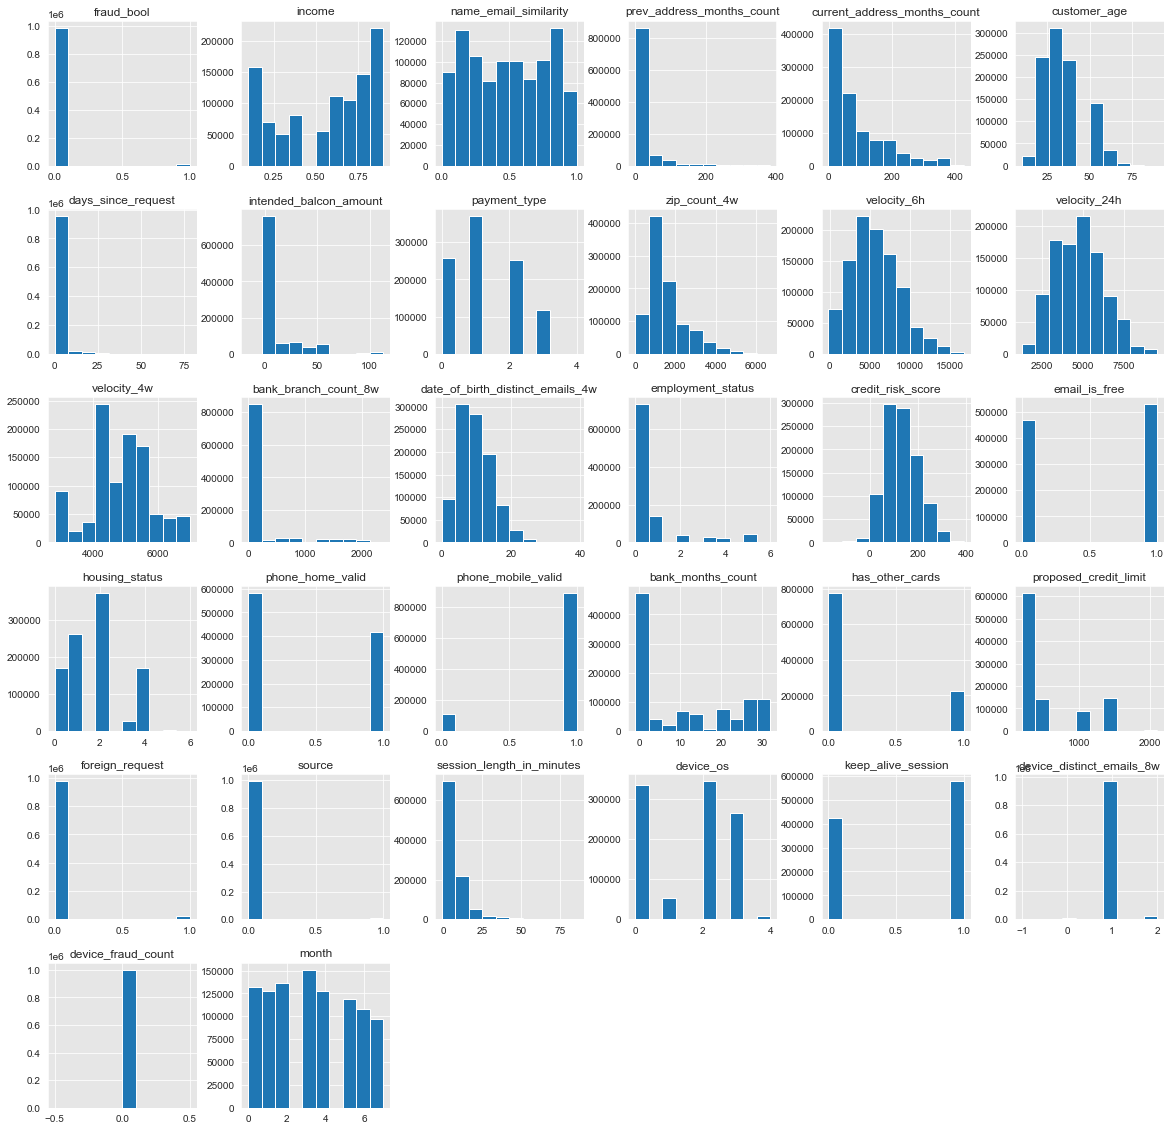

In [25]:
df.hist(figsize=(20,20));

Some of the feature values are not immediately comprehensible, but a detailed breakdown of each of the features can be found [here](https://github.com/feedzai/bank-account-fraud/blob/main/documents/datasheet.pdf). I want to check the correlation between the target variable and the other features. Because of the imbalanced nature of the data, the correlation scores should all be pretty low, but there may be a few features that stand out. I will also drop `device_fraud_count` since it contains only zeroes.

In [26]:
df.drop('device_fraud_count', axis=1, inplace=True)
df.corr()['fraud_bool'].sort_values(ascending=False)

fraud_bool                          1.000000
credit_risk_score                   0.070624
proposed_credit_limit               0.068907
customer_age                        0.062959
device_os                           0.057834
income                              0.045079
device_distinct_emails_8w           0.035704
current_address_months_count        0.033701
payment_type                        0.028304
email_is_free                       0.027758
foreign_request                     0.016885
month                               0.013250
session_length_in_minutes           0.008999
zip_count_4w                        0.005212
source                              0.003922
days_since_request                  0.000567
bank_months_count                  -0.003222
velocity_24h                       -0.011183
velocity_4w                        -0.011536
bank_branch_count_8w               -0.011577
phone_mobile_valid                 -0.013180
velocity_6h                        -0.016892
employment

As expected, most of the features are minimally correlated (`corr` < 0.05), but there are a few features on the positive and negative end that indicate a slightly stronger relationship. `credit_risk_score` and `housing_status` both have an absolute correlation of over 0.07, indicating that they may be more useful in determining fraud. This is an incredibly simplistic metric, but gives me a few things to consider as I move in to deeper analysis.

Next, I will prepare the data for modeling by splitting the data into training and test splits, and performing undersampling on the training set. The test set will not be altered. Undersampling will achieve 2 goals:

1. It allows the models to place more importance on identifying the fraudulent applications.
2. It reduces the overall number of datapoints. Due to technical limitations and the size of the original dataset, I am unable to build models in a reasonable fashion using the entire dataset.

Ideally, I could instead use oversampling on the positive class to solve issue 1. However, this would greatly exacerbate issue 2.

In [27]:
# create X and y dataframes
X = df.drop('fraud_bool', axis=1)
y = df['fraud_bool']

# train/test split determined by the month in which the data was gathered.
X_train = X[X['month'] < 6]
X_test = X[X['month'] >= 6]
y_train = y[X['month'] < 6]
y_test = y[X['month'] >= 6]

In [28]:
y_train.value_counts()

0    786838
1      8151
Name: fraud_bool, dtype: int64

In [29]:
y_test.value_counts()

0    202133
1      2878
Name: fraud_bool, dtype: int64

In [30]:
under_sampler = RandomUnderSampler(sampling_strategy=.1, random_state=seed)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)

y_train.value_counts()

0    81510
1     8151
Name: fraud_bool, dtype: int64

As seen above, the under-sampler has greatly reduced the number of non-faudulent datapoints in the training set.

## Modeling
***
Now that the data is prepared, I will iteratively create a series of models as I attempt to refine and improve upon each successive model. As mentioned above, I will be using Recall, also known as the true positive rate (TPR) at a set threshold of FPR = 0.05 to measure the effectiveness of each model. In this case, the FPR is 5%, which means that each of the models I create will have a false positive rate of 5%. From there, I will try to maximize the true positive rate. I will also use the ROC-AUC to judge the overall effectiveness of each model.

Since this is a classification task, I will begin with a relatively simple logistic regression model as my baseline to compare against future models. In total, I will build the following models:

- Logistic Regression
- KNN
- Random Forest
- Gradient Boosting
- Voting Classifier (seen in the evaluation section)

### Custom Functions

I will create several functions to help me measure and compare each model. The functions will include:

- custom scorer
- `ModelEval` class

The custom scorer will use `custom_tpr_func` to calculate the ROC curve and return the TPR at the set FPR of 0.05. This scorer will be used during cross-validation and hyperparameter tuning to determine the best model.

The `ModelEval` class will allow me to measure and store the key metrics for each model and compare them to previous models. The class includes methods for finding the cross-validation score, predictions on the training and test set, plotting the ROC curve, building a confusion matrix, and bias/fairness evaluation.

In [31]:
# create dataframes to compare various models
train_score_df = pd.DataFrame(columns = ['model name', 'tpr at fpr=.05', 'roc_auc'])
test_score_df = pd.DataFrame(columns = ['model name', 'tpr at fpr=.05', 'roc_auc'])

In [32]:
# scoring function to return the tpr at a set fpr
def custom_tpr_func(y_true, y_preds, fpr_max=fpr_max):
    
    fpr, tpr, thresholds = roc_curve(y_true, y_preds)
    
    score_tpr = tpr[fpr<=fpr_max][-1]
    
    return score_tpr

# custom scorer to use in cross validation
tpr_scorer = make_scorer(custom_tpr_func, greater_is_better=True, needs_threshold=True)

In [33]:
class ModelEval():
    '''
    Evaluate binary classifier models and perform fairness/bias analysis.
    
    This class consolidates the various tests and metrics needed to evaluate a given model
    on this binary classification problem. The class also provides methods for performing fairness and bias analysis.
    
    Parameters
    ----------
    model : an sklearn classifier-model object. Must already be instantiated.
    
    model_name : a string used to identify the model.
    
    train_score_df : a training set dataframe to contain the relevant metrics and compare different models.
    
    test_score_df : a test set dataframe to contain the relevant metrics and compare different models.
    
    fpr_max : the threshold used to set the maximum allowed false positive rate.
    '''
    
    def __init__(self, model, model_name, train_score_df, test_score_df, fpr_max=fpr_max):
        
        self.model = model
        self.model_name = model_name
        self.train_score_df = train_score_df
        self.test_score_df = test_score_df
        self.fpr_max = fpr_max
    
    def cv_proba(self, X_train, y_train, method, cv=5):
        '''
        Perform the `decision_function` or `predict_proba` method of the model using cross validation,
        and calculate the ROC curve.
        
        This method calculates the decision function or probability scores of an sklearn classifier
        object, and the resulting ROC curve. The classifier must have either a `decision_function`
        or `predict_proba` method.
        
        Adds the tpr and auc scores to `train_score_df` for comparison with other models.
        
        Parameters
        ----------
        X_train : training vector of shape (n_samples, n_features), where `n_samples` is the
            number of samples and `n_features` is the number of features.
                  
        y_train : target vector relative to X_train (n_samples,).
        
        method : string.
            Either `decision_function` or `predict_proba`.
        
        cv : integer used to specify the number of folds in a `(Stratified)KFold`.
        '''
        
        self.proba = cross_val_predict(self.model, X_train, y_train, cv=5, method=method)
        
        if method == 'decision_function':
            self.fpr, self.tpr, self.thresholds = roc_curve(y_train, self.proba)
        elif method == 'predict_proba':
            self.fpr, self.tpr, self.thresholds = roc_curve(y_train, self.proba[:,1])
        
        self.roc_auc = auc(self.fpr, self.tpr)
        
        # calculate scores at the determined fpr threshold
        self.score_fpr = self.fpr[self.fpr<=self.fpr_max][-1]
        self.score_tpr = self.tpr[self.fpr<=self.fpr_max][-1]
        self.score_threshold = self.thresholds[self.fpr<=self.fpr_max][-1]
        
        # add scores to dataframe for comparison with other models
        idx = train_score_df.shape[0]
        train_score_df.loc[idx] = [self.model_name, self.score_tpr, self.roc_auc]
           
    def test_proba(self, X_train, y_train, X_test, y_test, method):
        '''
        Calculate the `decision_function` or `predict_proba` method of the model on the test set.
        
        Operates similarly to the `cv_proba` method, but without cross validation.
        
        Adds the tpr and auc scores to `test_score_df` for comparison with other models.
        
        Parameters
        ----------
        X_train : training vector of shape (n_samples, n_features), where `n_samples` is the
            number of samples and `n_features` is the number of features.
                  
        y_train : target vector relative to X_train (n_samples,).
        
        X_test : test vector of shape (n_samples, n_features), where `n_samples` is the
            number of samples and `n_features` is the number of features.
                  
        y_test : test vector relative to X_test (n_samples,).
        
        method : string.
            Either `decision_function` or `predict_proba`. 
        '''
        
        self.model.fit(X_train, y_train)
        
        if method == 'decision_function':
            self.test_proba = self.model.decision_function(X_test)
            self.test_fpr, self.test_tpr, self.test_thresholds = roc_curve(y_test, self.test_proba)
            
        elif method == 'predict_proba':
            self.test_proba = self.model.predict_proba(X_test)[:,1] #trying this out to see if it works
            self.test_fpr, self.test_tpr, self.test_thresholds = roc_curve(y_test, self.test_proba) #took out the selector
        
        self.test_roc_auc = auc(self.test_fpr, self.test_tpr)
        
        # calculate scores at the determined fpr threshold
        self.test_score_fpr = self.test_fpr[self.test_fpr<=self.fpr_max][-1]
        self.test_score_tpr = self.test_tpr[self.test_fpr<=self.fpr_max][-1]
        self.test_score_threshold = self.test_thresholds[self.test_fpr<=self.fpr_max][-1]
        
        self.test_preds = (self.test_proba >= self.test_score_threshold).astype(int)
        
        # add scores to dataframe for comparison with other models
        idx = test_score_df.shape[0]
        test_score_df.loc[idx] = [self.model_name, self.test_score_tpr, self.test_roc_auc]
    
    def plot_roc(self, test_set=False):
        '''
        Plot the ROC curve of the fitted model.
        
        This method plots the ROC curve of the model and displays the auc and tpr at the fpr_max threshold.
        
        Parameters
        ----------
        test_set : if True, plots the ROC curve using model predictions on the test set.
            if False, plots the ROC curve using the cross-validated predictions on the training set.
        '''
        plt.rc('font', size=14)
        plt.rc('xtick', labelsize=10)
        plt.rc('ytick', labelsize=10)
            
        if test_set==False:
            # set text offset for readability
            horiz_offset = self.score_fpr*0.2
            
            plt.figure(figsize=(10, 8))
            lw = 2
            # plot roc-curve for cross-validated predictions
            plt.plot(self.fpr,
                     self.tpr,
                     color='darkorange',
                     lw=lw,
                     label=f'ROC AUC = {round(self.roc_auc, 2)}'
            )
            # plot diagonal line for reference
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            # plot point tpr at set fpr_max threshold
            plt.plot(self.score_fpr,
                     self.score_tpr,
                     marker="o",
                     markersize=5,
                     markeredgecolor="black",
                     markerfacecolor="black"
            )
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.yticks([i/20.0 for i in range(21)])
            plt.xticks([i/20.0 for i in range(21)])
            # display text for tpr at set fpr_max threshold
            plt.text(x=self.score_fpr + horiz_offset,
                     y=self.score_tpr,
                     s=f'TPR = {round(self.score_tpr, 2)}',
                     weight='semibold'
            )
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{self.model_name} ROC Curve (CV=5)')
            plt.legend(loc='lower right')
            
            return plt.show();
        
        elif test_set==True:
            # set text offset for readability
            horiz_offset = self.test_score_fpr*0.2
            
            plt.figure(figsize=(10, 8))
            lw = 2
            # plot roc-curve for test set predictions
            plt.plot(self.test_fpr,
                     self.test_tpr,
                     color='darkorange',
                     lw=lw,
                     label=f'ROC AUC = {round(self.test_roc_auc, 2)}'
            )
            # plot diagonal line for reference
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            # plot point tpr at set fpr_max threshold
            plt.plot(self.test_score_fpr,
                     self.test_score_tpr,
                     marker="o",
                     markersize=5,
                     markeredgecolor="black",
                     markerfacecolor="black"
            )
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.yticks([i/20.0 for i in range(21)])
            plt.xticks([i/20.0 for i in range(21)])
            # display text for tpr at set fpr_max threshold
            plt.text(x=self.test_score_fpr + horiz_offset,
                     y=self.test_score_tpr,
                     s=f'TPR = {round(self.test_score_tpr, 2)}',
                     weight='semibold'
            )
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{self.model_name} ROC Curve')
            plt.legend(loc='lower right')
            
            return plt.show();
        
    def cm(self, y_test):
        '''
        Create confusion matrix using sklearn's ConfusionMatrixDisplay().
        '''
        plt.rc('font', size=14)
        plt.rc('xtick', labelsize=10)
        plt.rc('ytick', labelsize=10)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        
        cm = confusion_matrix(y_test, self.test_preds)
        display = ConfusionMatrixDisplay(confusion_matrix=cm)
        display.plot(cmap='cividis', ax=ax, values_format='')
        
        plt.grid(False)
        
        return plt.show();

    def aq_tabs(self, attr_df, y_true):
        '''
        Create crosstab dataframe using the aequitas package.
        
        This method uses the aequtias package to create a crosstab dataframe
        using the predictions from the model. The resulting dataframe is needed
        in order to use the `aq_plot` method.
        
        Must first calculate `self.test_preds` from the `test_proba` method.
        
        Parameters
        ----------
        attr_df : dataframe containing all attributes (features) for fairness/bias analysis.
        
        y_true : 1-D array. Labels for the target variable.
        '''

        # create and concatenate necessary dataframes
        mod_id = pd.Series(self.model_name, name='model_id', index=attr_df.index)
        preds = pd.Series(self.test_preds, name='score', index=attr_df.index)
        y_true = pd.Series(y_true, name='label_value', index=attr_df.index)
        aq_df = pd.concat([mod_id, attr_df, y_true, preds], axis=1)
        
        # see aequitas documentation for more info
        g = Group()
        self.xtab, _ = g.get_crosstabs(aq_df)
        
    def aq_plot(self, metric):
        '''
        Create fairness/bias plot of subgroups using the aequitas package.
        
        Parameters
        ----------
        metric : string. Must be a column from the group table (xtab) from the `aq_tabs` method.
        '''
        # see aequitas documentation for more info
        aqp = Plot()
        if metric == 'tpr':
            metric_plot = aqp.plot_group_metric(self.xtab,
                                            group_metric=metric,
                                            title=self.model_name
            )
            
        else:
            metric_plot = aqp.plot_group_metric(self.xtab,
                                            group_metric=metric,
                                            ax_lim=0.6,
                                            title=self.model_name
            )
            
        
        return metric_plot

### Baseline Model: Logistic Regression

Logistic regression is good choice for a baseline model because of its relative speed, incomplexity, and interpretability. It uses a logistic function to model the target variable, which in this case is whether or not the bank account application is fraudulent. Logistic regression is ideal for modeling this type of binary classification, and calculates the probability that the event will happen or not (i.e. fraudulent or not).

I will scale the data first in order to allow for effective regularization, which should assist the model.

In [34]:
lr_scale_pipe = Pipeline([('scaler', StandardScaler()),
                          ('logreg', LogisticRegression(fit_intercept=False, solver='liblinear'))
                        ])

lr_scaled_eval = ModelEval(model=lr_scale_pipe,
                           model_name='logreg_scaled',
                           train_score_df=train_score_df,
                           test_score_df=test_score_df)

In [35]:
lr_scaled_eval.cv_proba(X_train, y_train, method='decision_function', cv=5)
train_score_df

,model name,tpr at fpr=.05,roc_auc
0,logreg_scaled,0.403386,0.83566


The model is only achieving 40% recall at the set threshold. This is far from ideal, but it provides a baseline.

### K-Nearest Neighbors (KNN)

KNN will be the next modeling method I attempt. KNN is capable of modeling multi-classification problems, but in this instance it will will be used to determine the binary classification of fraudulent or not. For any given datapoint, it uses the proximity of nearby datapoints to determine the proper classification. This is a computationally intensive method, and given the number of datapoints I am using, will require a good bit of time and computing to model. However, the added complexity will hopefully lead to a far more reliable model.

I will begin with a KNN model using the default hyperparameters, then perform a grid search to tune the hyperparameters. I must first scale the data, since the distance between datapoints is crucial to the success of the model.

In [36]:
knn = KNeighborsClassifier()
scale_pipe = Pipeline([('scaler', StandardScaler()),
                       ('knn', knn)
                      ])

In [37]:
knn_scaled_eval = ModelEval(scale_pipe,
                            'knn_scaled',
                            train_score_df=train_score_df,
                            test_score_df=test_score_df)

knn_scaled_eval.cv_proba(X_train, y_train, method='predict_proba', cv=5)
train_score_df

,model name,tpr at fpr=.05,roc_auc
0,logreg_scaled,0.403386,0.835660
1,knn_scaled,0.163170,0.705033


The results are underwhelming, but now I will tune the hyperparameters. I initially tested more hyperparameters, including `weights: ['uniform', 'distance']` and `p: [1,2,3]`. However, `weight='distance'` and `p=3` were consistently outperformed by the others, so to conserve time and computing power, I have limited this grid search to only test the relevant metrics.

In [38]:
knn_param_grid = {'knn__n_neighbors': [5,7,9], 'knn__p': [1, 2]}
knn_gs = GridSearchCV(scale_pipe, knn_param_grid, cv=5, scoring=tpr_scorer)
knn_gs.fit(X_train, y_train)
knn_gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=7, p=1))])

In [39]:
pd.DataFrame(knn_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.153570,0.983942,106.940541,1.832605,5,1,"{'knn__n_neighbors': 5, 'knn__p': 1}",0.177192,0.156442,0.144172,0.162577,0.195706,0.167218,0.017775,5
1,8.129680,0.805848,105.026460,4.298364,5,2,"{'knn__n_neighbors': 5, 'knn__p': 2}",0.187615,0.150920,0.112883,0.167485,0.196933,0.163167,0.029782,6
2,8.051456,0.249564,109.087029,2.419681,7,1,"{'knn__n_neighbors': 7, 'knn__p': 1}",0.278970,0.259509,0.235583,0.263804,0.310429,0.269659,0.024688,1
3,8.373491,0.451261,108.810675,1.005578,7,2,"{'knn__n_neighbors': 7, 'knn__p': 2}",0.299203,0.250920,0.201840,0.268098,0.317178,0.267448,0.040148,2
4,8.247230,0.664876,106.839839,3.826786,9,1,"{'knn__n_neighbors': 9, 'knn__p': 1}",0.239730,0.227607,0.192025,0.237423,0.272393,0.233836,0.025773,3
5,7.953967,0.169550,106.512852,2.507119,9,2,"{'knn__n_neighbors': 9, 'knn__p': 2}",0.266708,0.214724,0.170552,0.231902,0.277301,0.232237,0.038290,4


The best performing model hyperparameters are `n_neighbors=7` and `p=1`. I will use these for the final knn model, `knn_best`. 

In [40]:
knn_best = KNeighborsClassifier(n_neighbors=7, p=1)

knn_best_pipe = Pipeline([('scaler', StandardScaler()),
                          ('knn', knn_best)
                        ])

### Random Forests (RF)

The next modeling technique I will use is Random Forests. This is an ensemble method that randomly creates multiple decision trees and aggregates them to determine the classification of each datapoint. The results are somewhat more opaque than the other models, but may be able to outperform them.

In [41]:
rf = RandomForestClassifier()
rf_eval = ModelEval(rf,
                    'rf',
                    train_score_df=train_score_df,
                    test_score_df=test_score_df)

rf_eval.cv_proba(X_train, y_train, method='predict_proba', cv=5)
train_score_df

,model name,tpr at fpr=.05,roc_auc
0,logreg_scaled,0.403386,0.835660
1,knn_scaled,0.163170,0.705033
2,rf,0.338854,0.822775


Again, the results are far from impressive, but I will now tune hyperparameters in an attempt to improve upon the model.

In [42]:
rf_param_grid = {'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 10, 20],
                 'max_features': ['sqrt', None]}
rf_gs = GridSearchCV(rf, rf_param_grid, cv=5, scoring=tpr_scorer)
rf_gs.fit(X_train, y_train)
rf_gs.best_estimator_

RandomForestClassifier(max_depth=10, max_features='sqrt')

In [43]:
pd.DataFrame(rf_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,15.422195,0.321857,0.304282,0.014885,gini,None,sqrt,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.396076,0.336196,0.319018,0.279141,0.363190,0.338724,0.039579,5
1,92.423313,2.223075,0.330063,0.071612,gini,None,None,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.211527,0.321472,0.304908,0.300000,0.220245,0.271630,0.046150,10
2,10.362096,0.319014,0.179390,0.003896,gini,10,sqrt,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.518087,0.375460,0.324540,0.304294,0.450307,0.394538,0.079727,1
3,55.312234,0.469135,0.169723,0.002739,gini,10,None,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.277744,0.360736,0.325767,0.315337,0.268712,0.309659,0.033454,7
4,15.101886,0.143486,0.291837,0.005404,gini,20,sqrt,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.407112,0.349080,0.333742,0.294479,0.364417,0.349766,0.036925,3
5,90.780403,1.535365,0.289434,0.015315,gini,20,None,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.236665,0.340491,0.317791,0.300000,0.230061,0.285002,0.044123,9
6,18.531726,0.320863,0.283831,0.006444,entropy,None,sqrt,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.391784,0.330061,0.306135,0.232515,0.334969,0.319093,0.051614,6
7,95.830154,1.900229,0.250349,0.009401,entropy,None,None,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.217658,0.326994,0.297546,0.242331,0.188344,0.254575,0.050971,12
8,12.639318,0.107039,0.184316,0.006241,entropy,10,sqrt,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.513795,0.379755,0.319632,0.275460,0.466871,0.391103,0.088774,2
9,70.164046,0.472951,0.184331,0.006248,entropy,10,None,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.319436,0.360736,0.317791,0.233742,0.248466,0.296034,0.047645,8


`criterion='gini'` and `max_features='sqrt'` consistently outperform `criterion='entropy'` and `max_features='sqrt'`, so for the next gridsearch I will focus on `max_depth`.

In [44]:
rf_param_grid = {'criterion': ['gini'],
                 'max_depth': [ 6, 7, 8, 9, 10],
                 'max_features': ['sqrt']}
rf_gs = GridSearchCV(rf, rf_param_grid, cv=5, scoring=tpr_scorer)
rf_gs.fit(X_train, y_train)
rf_gs.best_estimator_

RandomForestClassifier(max_depth=7, max_features='sqrt')

In [45]:
pd.DataFrame(rf_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.184769,0.109976,0.121846,0.006248,gini,6,sqrt,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.528510,0.371779,0.349080,0.327607,0.522086,0.419812,0.087278,2
1,7.086244,0.042464,0.141666,0.002146,gini,7,sqrt,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.518700,0.381595,0.356442,0.355828,0.508589,0.424231,0.073665,1
2,7.894117,0.086746,0.185079,0.053935,gini,8,sqrt,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...",0.529736,0.373006,0.338037,0.344172,0.490184,0.415027,0.079398,3
3,8.721847,0.046667,0.159336,0.006250,gini,9,sqrt,"{'criterion': 'gini', 'max_depth': 9, 'max_fea...",0.515635,0.379141,0.348466,0.340491,0.480368,0.412820,0.071611,4
4,9.575797,0.064543,0.362414,0.373400,gini,10,sqrt,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.521766,0.374233,0.339264,0.324540,0.478528,0.407666,0.078418,5


In [59]:
rf_best = RandomForestClassifier(criterion='gini', max_depth=7, max_features='sqrt')

The random forest model slightly outperforms the logistic regression model.

### Gradient Boosting

For the next model, I will use a gradient boosting classifier. While this method and the random forest method both use decision trees, gradient boosting is a weak learner, meaning that it starts off slightly better than random guessing, and attempts to improve through the use of additional trees.

In [48]:
gbc = GradientBoostingClassifier(random_state=seed)
gbc_eval = ModelEval(gbc,
                     'gbc',
                     train_score_df=train_score_df,
                     test_score_df=test_score_df)

gbc_eval.cv_proba(X_train, y_train, method='predict_proba', cv=5)
train_score_df

,model name,tpr at fpr=.05,roc_auc
0,logreg_scaled,0.403386,0.835660
1,knn_scaled,0.163170,0.705033
2,rf,0.338854,0.822775
3,gbc,0.287081,0.785502


I performed a grid search with the following parameters, but have not included the code due to run time:

In [49]:
ex_param_grid = {'learning_rate': [.01, .1, 1, 10],
                 'n_estimators': [100, 200, 500],
                 'max_depth': [2,3,4,5]}

The best parameters were `GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=500)`. Low `learning_rate` and `max_depth` did well along with high `n_estimators`, so I will further optimize with another grid search.

In [50]:
gbc_param_grid = {'learning_rate': [.001, .01, .05],
                 'n_estimators': [400, 500, 600],
                 'max_depth': [1,2,3]}
gbc_gs = GridSearchCV(gbc, gbc_param_grid, cv=5, scoring=tpr_scorer)
gbc_gs.fit(X_train, y_train)
gbc_gs.best_estimator_

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=400,
                           random_state=99)

In [51]:
gbc_best = GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=400, random_state=99)

The model iterations continue to have slight performance increases over the previous models.

## Model Evaluation

Now that the models have been tuned and trained, I can evaluate them on the test set. I will plot the ROC curve with the AUC and TPR at the FPR threshold. Then I can compare to see which model performs the best.

In [52]:
lr_scaled_eval.test_proba(X_train, y_train, X_test, y_test, method='decision_function')

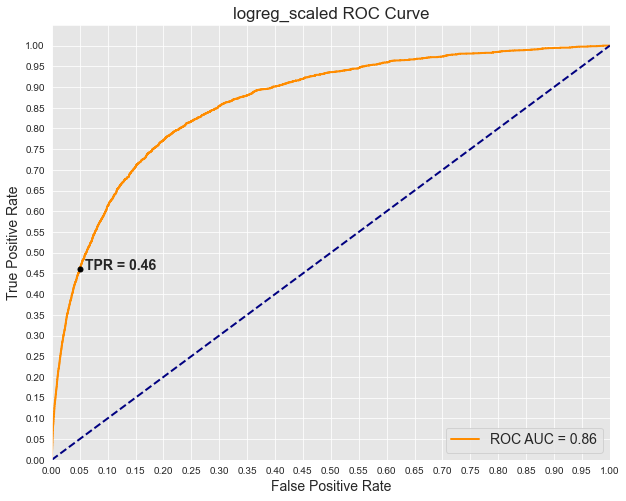

In [53]:
lr_scaled_eval.plot_roc(test_set=True)

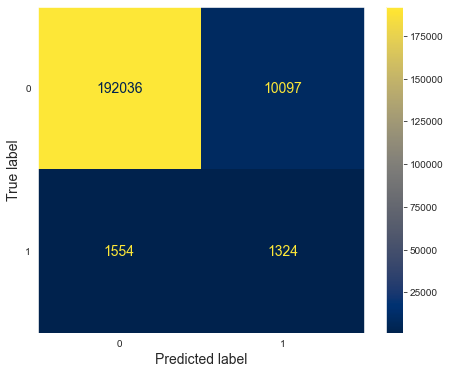

In [54]:
lr_scaled_eval.cm(y_test)

In [55]:
knn_best_eval = ModelEval(knn_best_pipe,
                          'best_knn',
                          train_score_df=train_score_df,
                          test_score_df=test_score_df)

knn_best_eval.test_proba(X_train, y_train, X_test, y_test, method='predict_proba')

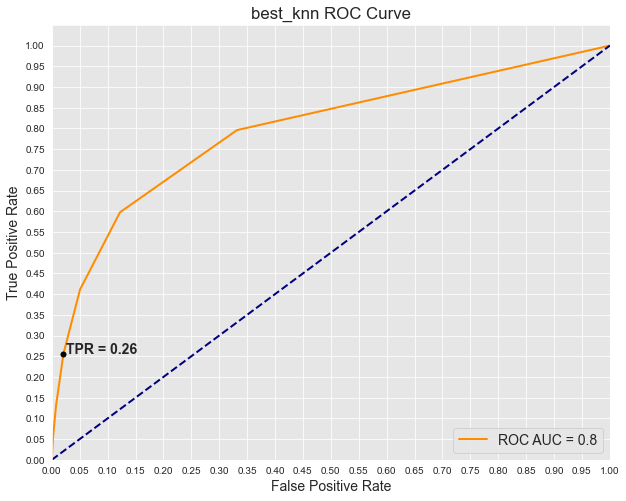

In [56]:
knn_best_eval.plot_roc(test_set=True)

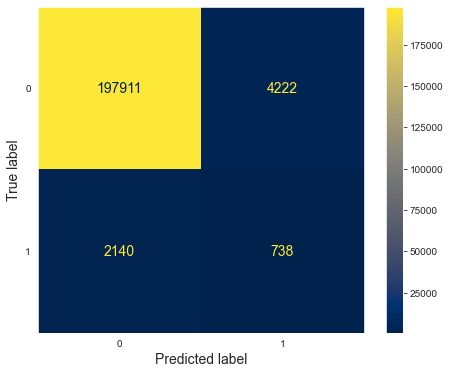

In [57]:
knn_best_eval.cm(y_test)

In [61]:
rf_best_eval = ModelEval(rf_best,
                         'best_rf',
                         train_score_df=train_score_df,
                         test_score_df=test_score_df)

rf_best_eval.test_proba(X_train, y_train, X_test, y_test, method='predict_proba')

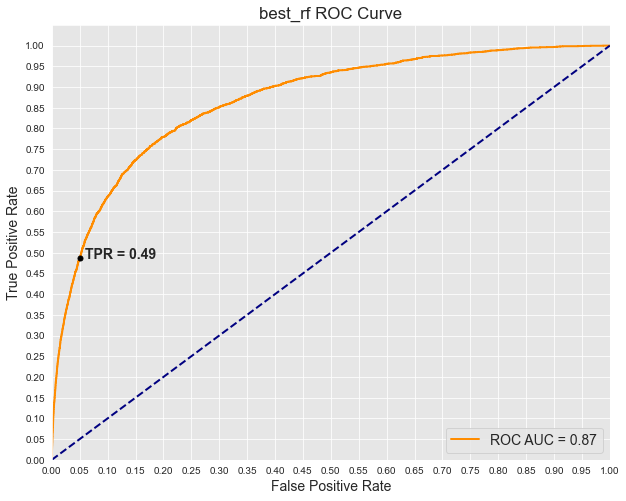

In [62]:
rf_best_eval.plot_roc(test_set=True)

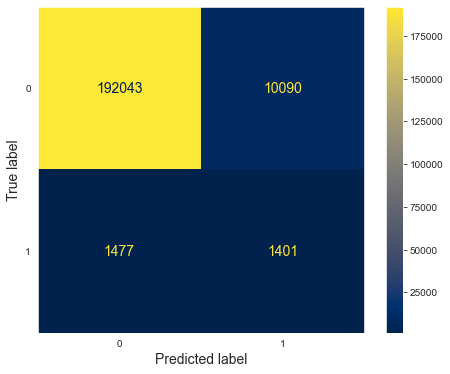

In [63]:
rf_best_eval.cm(y_test)

In [64]:
gbc_best_eval = ModelEval(gbc_best,
                          'best_gbc',
                          train_score_df=train_score_df,
                          test_score_df=test_score_df)

gbc_best_eval.test_proba(X_train, y_train, X_test, y_test, method='predict_proba')

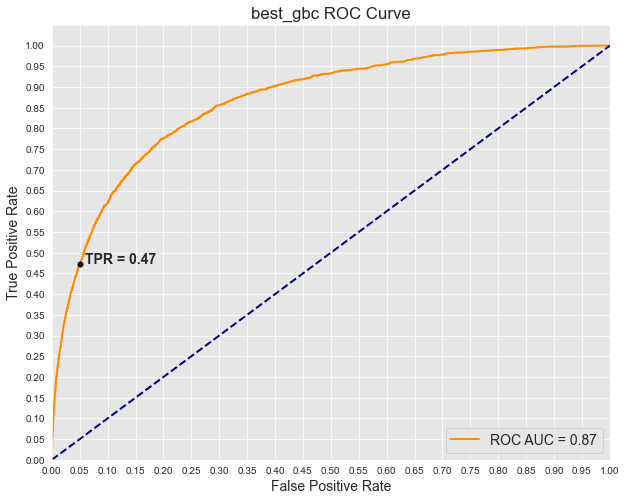

In [65]:
gbc_best_eval.plot_roc(test_set=True)

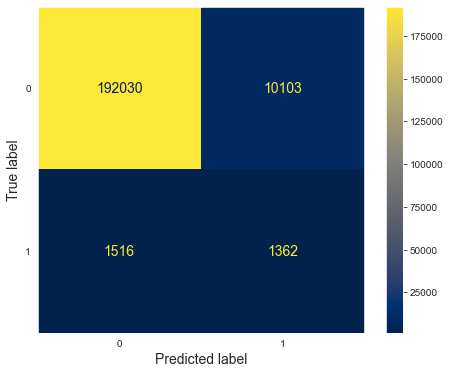

In [66]:
gbc_best_eval.cm(y_test)

In [67]:
test_score_df

,model name,tpr at fpr=.05,roc_auc
0,logreg_scaled,0.460042,0.862334
1,best_knn,0.256428,0.795280
2,best_rf,0.486796,0.867481
3,best_gbc,0.473245,0.865578


Of all the models, KNN performed the worse, with a TPR of around .42. The other three models were close, with the gradient boosting classifier having the highest TPR of .473. This is still not a great score, as the model only identifies less than half of the true fraud cases. However, I will now use these models to create one final model: a voting classifier.

### Voting Classifier

The voting classifier is an ensemble method that takes the predictions of other models and aggregates them to make a final prediction. If `voting='hard'`, the classifier ignores the probabilities and focuses on the final prediction of each model as a 'vote' for the final outcome. I will be using `voting='soft'`, which combines the probabilities of each model's predictions to decide the final outcome.

Since KNN performed significantly worse than the other three models, I will leave it out from the voting classifier, and focus solely on the linear regression, random forest, and gradient boosting classifier. I am hopeful that because the classifiers are varied in their prediction methods, combining them in the voting classifier will provide a boost to the final model's score.

In [68]:
vc = VotingClassifier(estimators=[('lr', lr_scale_pipe),
                                  ('rf', rf_best),
                                  ('gbc', gbc_best)
                                 ],
                      voting='soft')

In [69]:
vc_eval = ModelEval(vc,
                    'vc',
                    train_score_df=train_score_df,
                    test_score_df=test_score_df)

vc_eval.test_proba(X_train, y_train, X_test, y_test, method='predict_proba')

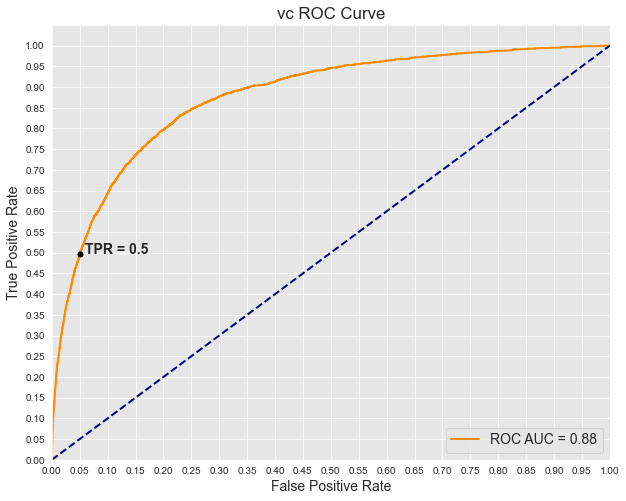

In [70]:
vc_eval.plot_roc(test_set=True)

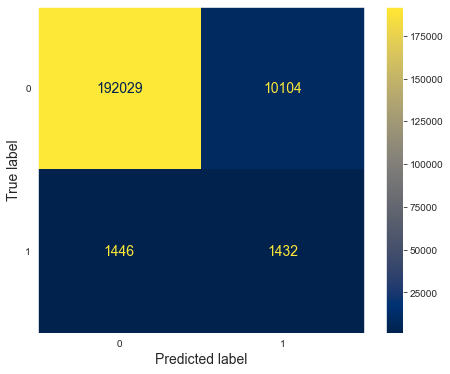

In [71]:
vc_eval.cm(y_test)

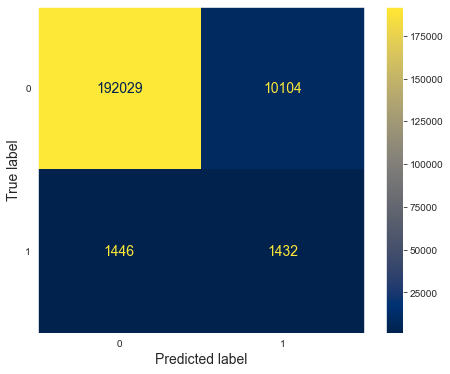

<Figure size 432x288 with 0 Axes>

In [117]:
vc_eval.cm(y_test)
plt.savefig('vc_conf_matrix', bbox_inches='tight')

In [72]:
test_score_df

,model name,tpr at fpr=.05,roc_auc
0,logreg_scaled,0.460042,0.862334
1,best_knn,0.256428,0.795280
2,best_rf,0.486796,0.867481
3,best_gbc,0.473245,0.865578
4,vc,0.497568,0.875679


As I had hoped, the voting classifier did outperform the other models. The TPR of .487 beat the previous best of .473 from the gradient boosting classifier. In practice, this means an extra 41 cases of fraud that were positively identified, while reducing the false positives by 41.

The model's performance is still underwhelming, and it is safe to assume that banks would be uninterested in utilizing a model that performs at this level. However, given the technical constraints, it is the best that can be done for now.

Now that the models are finalized, I will evaluate each one for signs of bias among the proctected classes.

## Bias and Fairness Metrics

To evaluate bias and fairness, I will be using the [Aequitas Fairness and Bias Audit Toolkit](https://dssg.github.io/aequitas/index.html), a python package designed to evaluate models and data for bias. In order to use Aequitas, I will need to do some additional preprocessing, including:

- create a new dataframe with `attr_cols` (the features we wish to examine for bias), `model_id`, `label_value` (the true y values), and `score` (the model predictions).
- change all `attr_cols` to strings
- bin the `attr_cols` as needed.

To achieve this, I have created the `aq_tabs` method in my `ModelEval()` class. It is worth noting that most of this preprocessing can be done by the Aequitas package using the `preprocess_input_df` method, but the drawback is that the method will auto-bin the `attr_cols`. Since I want to be able to control/adjust my bins, I will preprocess the data myself.

In [96]:
bias_groups = ['income', 'customer_age', 'employment_status']
aq_test = X_test[bias_groups]
# change `income` dtype separately to prevent rounding issues
aq_test['income'] = round(aq_test['income'], 1).astype(str)
aq_test = aq_test.astype(str)

In [97]:
lr_scaled_eval.aq_tabs(aq_test, y_test)

In [98]:
lr_scaled_eval.xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,logreg_scaled,binary 0/1,11421,income,0.1,0.254658,0.985605,0.005397,0.887363,0.014395,...,0.016106,323,120,22116,41,161,22439,22600,205011,0.007124
1,logreg_scaled,binary 0/1,11421,income,0.2,0.259740,0.982857,0.005151,0.905660,0.017143,...,0.018799,192,57,11008,20,77,11200,11277,205011,0.006828
2,logreg_scaled,binary 0/1,11421,income,0.3,0.408451,0.978952,0.005047,0.859903,0.021048,...,0.024273,178,42,8279,29,71,8457,8528,205011,0.008326
3,logreg_scaled,binary 0/1,11421,income,0.4,0.389706,0.972619,0.005881,0.881696,0.027381,...,0.030765,395,83,14031,53,136,14426,14562,205011,0.009339
4,logreg_scaled,binary 0/1,11421,income,0.5,0.351064,0.966535,0.006173,0.911528,0.033465,...,0.036376,340,61,9820,33,94,10160,10254,205011,0.009167
5,logreg_scaled,binary 0/1,11421,income,0.6,0.358650,0.963512,0.007188,0.903409,0.036488,...,0.039955,795,152,20993,85,237,21788,22025,205011,0.010760
6,logreg_scaled,binary 0/1,11421,income,0.7,0.363636,0.954937,0.006629,0.925234,0.045063,...,0.048222,990,140,20979,80,220,21969,22189,205011,0.009915
7,logreg_scaled,binary 0/1,11421,income,0.8,0.429293,0.944705,0.006995,0.916992,0.055295,...,0.059606,1878,226,32085,170,396,33963,34359,205011,0.011525
8,logreg_scaled,binary 0/1,11421,income,0.9,0.547106,0.913287,0.012603,0.860285,0.086713,...,0.098266,5006,673,52725,813,1486,57731,59217,205011,0.025094
9,logreg_scaled,binary 0/1,11421,customer_age,10,0.090909,0.996453,0.003940,0.900000,0.003547,...,0.003925,18,20,5056,2,22,5074,5096,205011,0.004317


The crosstab dataframe above contains a lot of metrics for each subgroup. For this analysis, I will be focusing on the FPR of each subgroup. This is because in the context of fraudulent bank account applications, a false positive means that the person is being denied access to financial services (a punative decision). 

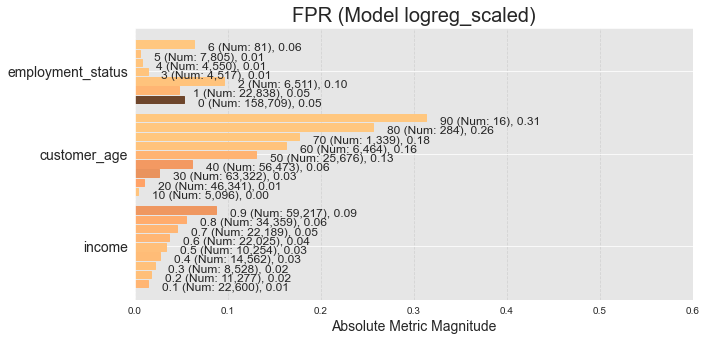

In [99]:
lr_scaled_eval.aq_plot('fpr');

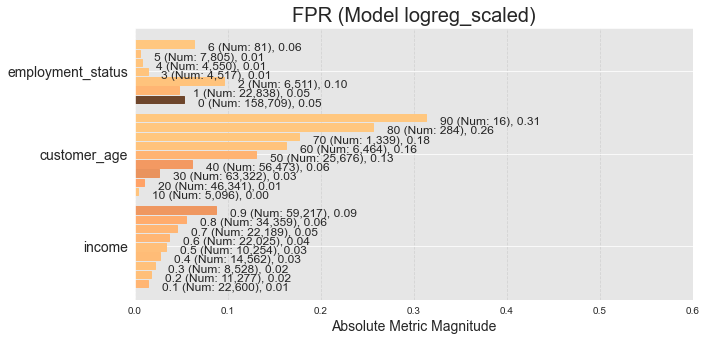

In [100]:
lr_scaled_eval.aq_plot('fpr');

In [101]:
knn_tabs = knn_best_eval.aq_tabs(aq_test, y_test)

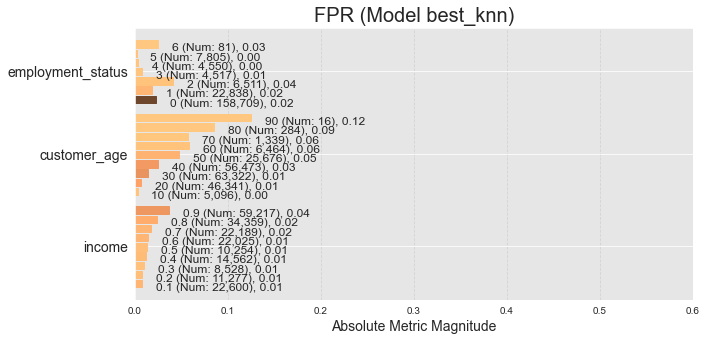

In [102]:
knn_best_eval.aq_plot('fpr');

In [103]:
rf_best_eval.aq_tabs(aq_test, y_test)

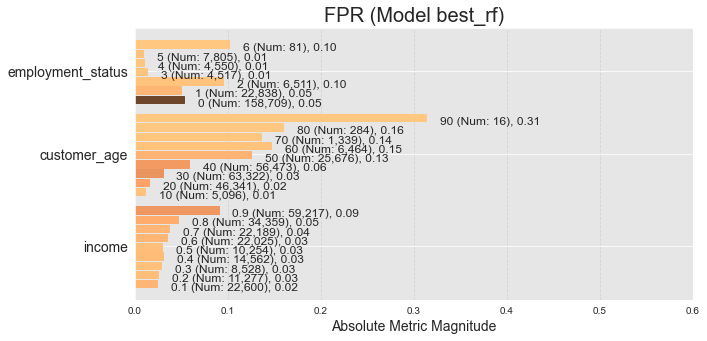

In [104]:
rf_best_eval.aq_plot('fpr');

In [105]:
gbc_best_eval.aq_tabs(aq_test, y_test)

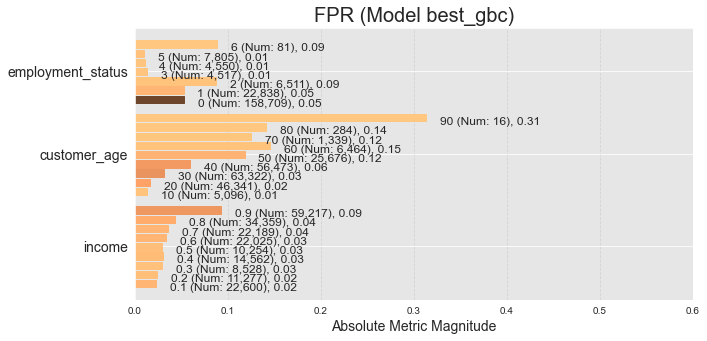

In [106]:
gbc_best_eval.aq_plot('fpr');

In [107]:
vc_eval.aq_tabs(aq_test, y_test)

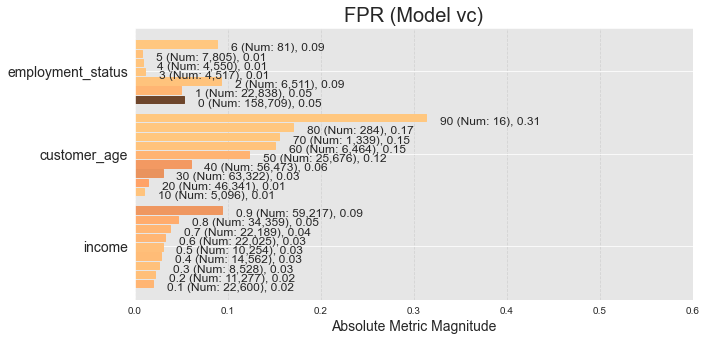

In [108]:
vc_eval.aq_plot('fpr');

Interestingly, the subgroup FPR ratios are similar for all models except the KNN model, which was also an outlier in terms of performance.

In terms of bias, the older an applicant, the higher the chance of a false positive. The 90+ `age` group is the most likely, at .31 FPR, but this could partially be due to the small sample size. The subgroup has 16 observations, but not a single true positive.

For `income`, a higher income has a likelier chance of fales positives. However, how does this compare to the TPR for the same groups?

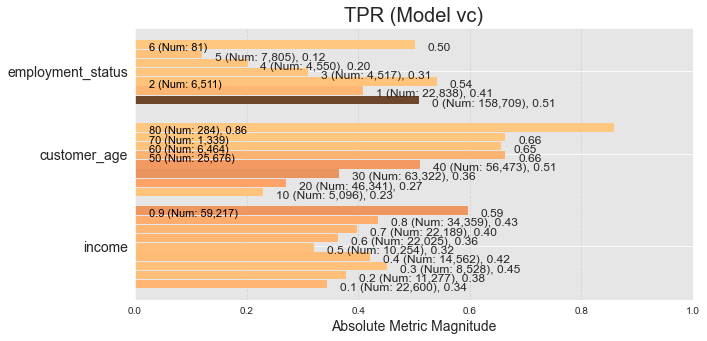

In [110]:
vc_eval.aq_plot('tpr');

We can see that while high income applicants have a higher chance of receiving a false positive, the model also corrects identifies the highest portion of true positives.

It is also important to note how the subgroup selection affects the results. I will create new subgroups by binning the `age` group into `over_50` and `under_50`. Likewise, I will split the `income` group into `high` and `low` income, and see how the FPR changes for the voting classifier.

In [111]:
aq_bin = X_test[bias_groups]
aq_bin['income'] = pd.cut(aq_bin['income'],
                          [0, 0.5, 1], 
                          labels = ['low', 'high'])

aq_bin['customer_age'] = pd.cut(aq_bin['customer_age'],
                                [0, 50, 100],
                                labels=['under_50', 'over_50'])

aq_bin = aq_bin.astype(str)
aq_bin

,income,customer_age,employment_status
0,high,under_50,0
1,high,under_50,0
2,high,under_50,1
3,high,under_50,0
4,high,under_50,0
...,...,...,...
620541,high,under_50,0
620542,high,under_50,0
620543,low,under_50,1
620544,low,under_50,0


In [112]:
vc_eval.aq_tabs(aq_bin, y_test)

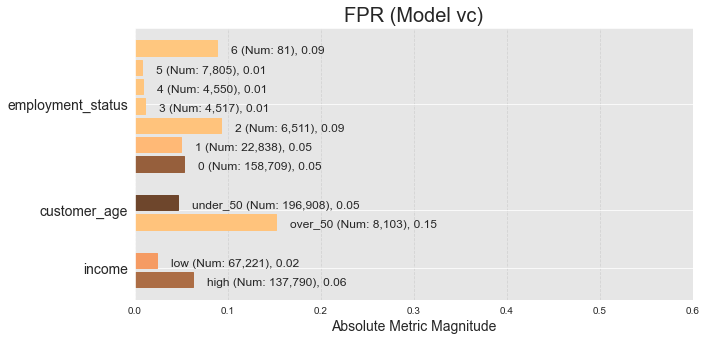

In [113]:
vc_eval.aq_plot('fpr');

As seen above, this small change can greatly affect the ratios. However, it is important to note that the models were not trained using these categories. Ideally, the models should be re-trained using the new categories to see how performance and bias is affected.

## Conclusion

After a thorough investigation of bank application fraud detection, here are a few things that stand out:

- I was unable to build a model that would prove satisfactory for the banks, as the model performance was lacking.
- the models did show signs of bias, particularly regarding the age category.
- the best performing models did share similarities in their bias/fairness metrics. Other modeling techniques should be investigated to test the impact of model selection in more detail.

Ultimately, the results are inconclusive. The models will need to perform better in order for the banks to consider using them, while the fairness and bias of the models continues to be an issue. However, hopefully this analysis will prove useful for others attempting a similar task.